In [1]:
from __future__ import print_function, division
from builtins import range, input

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime

In [2]:
# load in the data
import os
if not os.path.exists('user2movie.json') or \
   not os.path.exists('movie2user.json') or \
   not os.path.exists('usermovie2rating.json') or \
   not os.path.exists('usermovie2rating_test.json'):
   import preprocess2dict

In [3]:
with open('user2movie.json', 'rb') as f:
  user2movie = pickle.load(f)

with open('movie2user.json', 'rb') as f:
  movie2user = pickle.load(f)

with open('usermovie2rating.json', 'rb') as f:
  usermovie2rating = pickle.load(f)

with open('usermovie2rating_test.json', 'rb') as f:
  usermovie2rating_test = pickle.load(f)

In [4]:
N = np.max(list(user2movie.keys())) + 1
# the test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)

N: 10000 M: 2000


In [5]:
# convert user2movie and movie2user to include ratings
print("converting...")
user2movierating = {}
for i, movies in user2movie.items():
    r = np.array([usermovie2rating[(i, j)] for j in movies])
    user2movierating[i] = (movies, r)
movie2userrating = {}
for j, users in movie2user.items():
    r = np.array([usermovie2rating[(i, j)] for i in users])
    movie2userrating[j] = (users, r)

# create a movie2user for test set, since we need it for loss
movie2userrating_test = {}
for (i, j), r in usermovie2rating_test.items():
    if j not in movie2userrating_test:
        movie2userrating_test[j] = [[i], [j]]
    else:
        movie2userrating_test[j][0].append(i)
        movie2userrating_test[j][1].append(r)
for j, (users, r) in movie2userrating_test.items():
    movie2userrating_test[j][1] = np.array(r)
print("conversion done")

converting...
conversion done


In [6]:
# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(usermovie2rating.values()))

In [7]:
def get_loss(m2u):
    # d: movie_id -> (user_ids, ratings)
    N = 0.
    sse = 0
    for j, (u_ids, r) in m2u.items():
        p = W[u_ids].dot(U[j]) + b[u_ids] + c[j] + mu
        delta = p - r
        sse += delta.dot(delta)
        N += len(r)
    return sse / N

epoch: 0
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 7000 N: 10000
i: 8000 N: 10000
i: 9000 N: 10000
updated W and b: 0:00:08.533912
j: 0 M: 2000
j: 200 M: 2000
j: 400 M: 2000
j: 600 M: 2000
j: 800 M: 2000
j: 1000 M: 2000
j: 1200 M: 2000
j: 1400 M: 2000
j: 1600 M: 2000
j: 1800 M: 2000
updated U and c: 0:00:05.926122
epoch duration: 0:00:14.461063
calculate cost: 0:00:02.600902
train loss: 0.6904445662689384
test loss: 2459.3582179635555
epoch: 1
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 7000 N: 10000
i: 8000 N: 10000
i: 9000 N: 10000
updated W and b: 0:00:06.952486
j: 0 M: 2000
j: 200 M: 2000
j: 400 M: 2000
j: 600 M: 2000
j: 800 M: 2000
j: 1000 M: 2000
j: 1200 M: 2000
j: 1400 M: 2000
j: 1600 M: 2000
j: 1800 M: 2000
updated U and c: 0:00:05.465832
epoch duration: 0:00:12.419430
calculate cost: 0:00:03.081096
train loss: 0.567405234787160

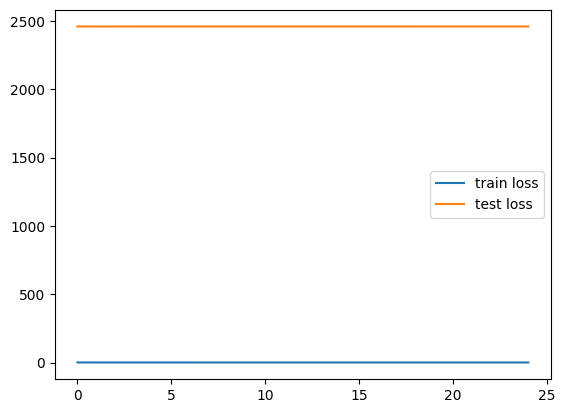

In [8]:
# train the parameters
epochs = 25
reg =20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.now()
    # perform updates

    # update W and b
    t0 = datetime.now()
    for i in range(N):
        m_ids, r = user2movierating[i]
        matrix = U[m_ids].T.dot(U[m_ids]) + np.eye(K) * reg
        vector = (r - b[i] - c[m_ids] - mu).dot(U[m_ids])
        bi = (r - U[m_ids].dot(W[i]) - c[m_ids] - mu).sum()

        # set the updates
        W[i] = np.linalg.solve(matrix, vector)
        b[i] = bi / (len(user2movie[i]) + reg)

        if i % (N//10) == 0:
            print("i:", i, "N:", N)
    print("updated W and b:", datetime.now() - t0)

    # update U and c
    t0 = datetime.now()
    for j in range(M):
        try:
            u_ids, r = movie2userrating[j]
            matrix = W[u_ids].T.dot(W[u_ids]) + np.eye(K) * reg
            vector = (r - b[u_ids] - c[j] - mu).dot(W[u_ids])
            cj = (r - W[u_ids].dot(U[j]) - b[u_ids] - mu).sum()

            # set the updates
            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj / (len(movie2user[j]) + reg)

            if j% (M//10) == 0:
                print("j:", j, "M:", M)
        except KeyError:
            # possible not to have any ratings for a movie
            pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)
    
    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(movie2userrating))

    # store test loss
    test_losses.append(get_loss(movie2userrating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])

print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()